# References

- Training loop basics:<br>https://www.tensorflow.org/guide/basic_training_loops
- Meaning of learning rate:<br>https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
- Meaning of epochs in machine learning:<br>https://radiopaedia.org/articles/epoch-machine-learning
- About Keras:<br>https://keras.io/about/
- About Keras optimizers:<br>https://keras.io/api/optimizers/
- TypeError: \_\_call\_\_( ) got an unexpected keyword argument 'training'<br>https://github.com/tensorflow/nmt/issues/471

# Necessary imports

In [335]:
import tensorflow as tf # For accessing TensorFlow library
import matplotlib.pyplot as plt # For plotting graphs

# Definition

A training loop is the process wherein a model is repeatedly applied for a batch of inputs and altered based on the difference between the actual and expected outputs. A training loop consists of repeatedly doing four tasks in order:
- Sending a batch of inputs through the model to generate outputs
- Calculating the loss by comparing the model's outputs to the expected outputs (or labels)
- Using gradient tape to find the gradients
- Optimizing the variables with those gradients

# General process

## Note on machine learning process

Solving a machine learning problem usually consists of the following steps:
- Obtain training data
- Define the model
- Define a loss function
- Run through the training data, calculating loss from the expected value
- Calculate gradients for the loss function
- Use an optimizer to adjust the variables to fit the data
- Evaluate your results

Supervised learning uses inputs (usually denoted as x) and outputs (denoted y, often called labels). The goal is to learn from paired inputs and outputs so that you can predict the value of an output from an input.
<br><br>
Each input of your data, in TensorFlow, is almost always represented by a tensor, and is often a vector. In supervised training, the output / target value (i.e. the value you want to predict) is also a tensor.

## Steps for creating a training loop

- Defining a model
- Defining a loss function
- Make a training function (call it **train**) to
    - Compute model output for a given input (feature) batch
    - Calculate partial gradient for the loss function w.r.t. each model weight and bias
    - Use the respective gradients to update model weights and biases
- Make a training loop function (call it **trainingLoop**) to
    - Repeatedly apply the **train** function for multiple input batches

**NOTE 1**: Input (feature) batches may consist of the same data passed over and over.<br>
**NOTE 2**: A model is generally the implementation of a machine learning algorithm.

# PRELIMINARY STEP: Obtaining training data

## Creating data

_(Too lazy to get actual data)_

In [336]:
# Data size
dataSize = 100
#========================
# Inputs
x = tf.linspace(-2, 2, dataSize)
x = tf.cast(x, tf.float32)
# Casting is done to ensure inputs are of the correct data type.
# (There are multiple subcategories under float also i.e. float32 and float64)
#========================
# Target outputs
trueWeight = 2.1 # True weight (that the model must try to attain through training)
trueBias = 3.0 # True bias (that the model must try to attain through training)
noise = tf.random.normal(shape=[dataSize]) # Adding some randomness to the target values
"""
Most real life data have some extraneous influences, causing some irregular fluctuations.
We are trying to imitate that using random values drawn from a normal distribution.
We could specify the normal distribution, but here, we are okay with the default.
In the default, mean = 0, standard deviation = 1.
"""
target_y = trueWeight * x + trueBias + noise
target_y = tf.cast(target_y, tf.float32)

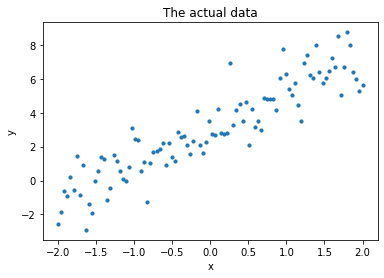

In [337]:
# Viewing the data
plt.scatter(x, target_y, marker="o", s=10) # s denotes marker size
plt.title("The actual data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# PART A: Basic ML using simple TensorFlow models

## Defining a model

A simple linear model. This is generally the implementation of a machine learning algorithm, that can be called as necessary.

In [338]:
class MyModel(tf.Module):
    def __init__(self, **kwargs): # To allow for any number of possible keyword arguments
        super().__init__(**kwargs)
        # Creating weight(s) and bias with some constant values
        self.w = tf.Variable(5, dtype=tf.float32, name='weight')
        self.b = tf.Variable(0, dtype=tf.float32, name='bias')
        # name is not necessary.
        # dtype is not necessary here, I can just give 5.0 instead of 5.
        # The above are done merely for conceptual clarity
        
    # Creating model output function
    def __call__(self, x): # x => input i.e. feature variable
        return self.w * x + self.b # Simple linear regression

In [339]:
# Instantiating the above model class
model = MyModel()

# Checking if the model is properly created
print("\nModel variables: ")
for v in model.variables: print(v)
print("\nModel output for x = 3: ")
print(model(3))


Model variables: 
<tf.Variable 'bias:0' shape=() dtype=float32, numpy=0.0>
<tf.Variable 'weight:0' shape=() dtype=float32, numpy=5.0>

Model output for x = 3: 
tf.Tensor(15.0, shape=(), dtype=float32)


## Defining loss function

In [340]:
def loss(target_y, predicted_y): # predicted_y => y value as predicted by model
    return tf.reduce_mean(tf.square(target_y - predicted_y))
# tf.reduce_mean simply calculates the mean of the values.
# Calculating mean is necessary for batch of inputs, not single inputs.
# But we aim to provide batches of inputs, not single inputs.
# Hence, the loss function calculates the mean error square for the given inputs.

## Defining training function

In [341]:
def train(model, x, target_y, learningRate):
    # Recording loss function's computation process in the context of the GradientTape API
    # (the relevant operations are stored in a 'tape' data structure)
    with tf.GradientTape() as tape:
        currentLoss = loss(target_y, model(x))
    # NOTE: Trainable variables are automatically tracked by the GradientTape API.
    
    # Obtaining gradients of the loss function using the above created tape
    # Gradient of loss function with respect to weight & bias separately
    # (for the given input)...
    dl_dw, dl_db = tape.gradient(currentLoss, [model.w, model.b])
    
    # Subtract the respective partial gradients scaled by the learning rate
    model.w.assign_sub(learningRate * dl_dw)
    model.b.assign_sub(learningRate * dl_db)
    # The above two lines of code implement gradient descent.
    # Gradient descent is a type of optimizer (i.e. function used optimize a model)
    """
    model.var.assign_sub(k)
    - subtracts k from the current value of model.var
    - reassigns model.var with the result
    
    NOTE: It combines tf.assign and tf.sub
    """

**NOTE ON LEARNING RATE**:<br>
The learning rate is a value that controls how much the model's parameters change in response to the estimated error (i.e. at what rate are model weights updated). Too small learning rate may result in a longer training process that could get stuck at an undesirable accuracy. Too large learning rate may result in an unstable training process that could skip over more optimal model weights.

## Defining training loop function

A function to repeatedly apply the training function to the same inputs (to hopefully achieve a more accurate model).

In [342]:
# Creating lists to track the evolution of the weight(s) and bias of the model
weights, biases = [], []

# The training loop
def trainingLoop(mode, x, target_y):
    # Defining the number of epochs
    maxEpochs = 10
    # Defining learning rate
    learningRate = 0.1
    
    # Loop
    epoch = 0
    while epoch < maxEpochs:
        #========================
        # TRACKING PROGRESS
        # (this is merely for reference)
        #------------
        print("\n------------\nEPOCH", epoch)
        # Appending the weights to the evolution tracking lists
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        
        # Tracking the loss function
        print("w =", model.w.numpy())
        print("b =", model.b.numpy())
        currentLoss = loss(target_y, model(x)) # Calculating the loss function value
        print("loss =", currentLoss.numpy())
        #========================
        # UPDATING MODEL
        # (this is the main part)
         #------------
        train(model, x, target_y, learningRate) # Applying the training function
        epoch = epoch + 1

**NOTE ON EPOCH**:<br>
An epoch is the number of times the entire training dataset has been run through by the machine learning algorithm (i.e. model in our case) has completed _(i.e. number of passes of the entire training dataset that the machine learning algorithm has completed)_.
<br><br>
Datasets are usually grouped into batches (especially for large amounts of data). Let us define an iteration as the processing of a single batch into the machine learning algorithm. If the batch size is the whole training dataset, then the number of epochs is the number of iterations. If the batch size is smaller, then the number of epochs is given by<br>**number of iterations / number of batches**.

## Application

### Training loop process

Applying training loop for the model, given the above data...

In [343]:
trainingLoop(model, x, target_y)


------------
EPOCH 0
w = 5.0
b = 0.0
loss = 21.87017

------------
EPOCH 1
w = 4.218092
b = 0.6138654
loss = 13.196536

------------
EPOCH 2
w = 3.6489053
b = 1.1049577
loss = 8.226946

------------
EPOCH 3
w = 3.2345679
b = 1.4978316
loss = 5.3545666

------------
EPOCH 4
w = 2.9329526
b = 1.8121307
loss = 3.6795397

------------
EPOCH 5
w = 2.713393
b = 2.06357
loss = 2.694054

------------
EPOCH 6
w = 2.5535655
b = 2.2647214
loss = 2.1091964

------------
EPOCH 7
w = 2.4372196
b = 2.4256425
loss = 1.7591854

------------
EPOCH 8
w = 2.3525262
b = 2.5543795
loss = 1.5480539

------------
EPOCH 9
w = 2.2908738
b = 2.657369
loss = 1.4197526


Updated weight and bias: (2.245994, 2.7397606)


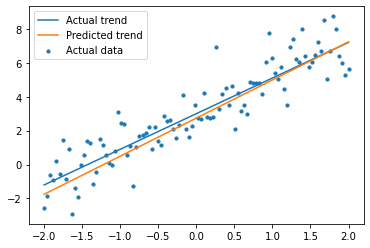

In [344]:
print("Updated weight and bias:", (model.w.numpy(), model.b.numpy()))
plt.scatter(x, target_y, marker='o', s=10, label='Actual data')
plt.plot(x, trueWeight * x + trueBias, label='Actual trend')
plt.plot(x, model(x), label='Predicted trend')
plt.legend()
plt.show()

### Weight & bias evolution

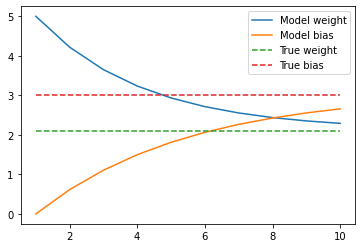

In [346]:
epochs = list(range(1, len(weights) + 1))
plt.plot(epochs, weights, label='Model weight')
plt.plot(epochs, biases, label='Model bias')
plt.plot(epochs, [trueWeight]*len(weights), '--', label="True weight")
plt.plot(epochs, [trueBias]*len(weights), '--', label="True bias")
plt.legend()
plt.show()

# PART B: Basic ML using Keras

## Brief introduction to Keras

*Keras is a deep learning API that runs on top of TensorFlow. It was developed with a focus on enabling fast experimentation. It provides abstractions for various kinds of deep learning concepts and techniques, including sequential models and training loops (like the one implemented above). Note that Keras models ultimately inherit from the **module** class in TensorFlow.

## Preliminary notes

You can create a Keras model in the same way as a regular TensorFlow model, with the difference being that you must inherit from **tf.keras.Model**, instead of **tf.Module**. This model can be processed in the training loop in the same way. An additional feature of a Keras model is that can also save a checkpoint using Keras's built-in support, in the following manner:<br>
**myKerasModel.save_weights("my_checkpoint")**
<br><br>
Another additional feature is that you can store the loss function and optimizer functions (which are used to update model weights and biases) as attributes of the Keras model.

## Defining a model

In [385]:
class MyKerasModel(tf.keras.Model):
    def __init__(self, **kwargs): # To allow for any number of possible keyword arguments
        super().__init__(**kwargs)
        # Creating weight(s) and bias with some constant values
        self.w = tf.Variable(5, dtype=tf.float32, name='weight')
        self.b = tf.Variable(0, dtype=tf.float32, name='bias')
        # name is not necessary.
        # dtype is not necessary here, I can just give 5.0 instead of 5.
        # The above are done merely for conceptual clarity
        
    # Creating model output function
    def __call__(self, x, training=False): # x => input
        return self.w * x + self.b # Simple linear model

**NOTE ON 'training=True/False'**:<br>
    When I had not put this argument, when applying the **.fit** function on my Keras model (see below), I got the error `TypeError: __call__() got an unexpected keyword argument 'training`. I did not get the error when I passed the keyword argument **training** as **True**, **False** or **None**. I am not sure about the details yet.

In [386]:
# Instantiating the above model class
kerasModel = MyKerasModel()

# Checking if the model is properly created
print("\nModel variables: ")
for v in kerasModel.variables: print(v)
print("\nModel output for x = 3: ")
print(kerasModel(3))


Model variables: 
<tf.Variable 'weight:0' shape=() dtype=float32, numpy=5.0>
<tf.Variable 'bias:0' shape=() dtype=float32, numpy=0.0>

Model output for x = 3: 
tf.Tensor(15.0, shape=(), dtype=float32)


## Defining training function (sort of)

Rather than write new training function each time you create a model, you can use the built-in features of Keras as a shortcut. However, if you want to create your training function, you can use the **.compile** function (which are attributes of Keras models) to set the training function's parameters. This function allows you to define a loss and optimizer function (i.e. a function used to update weights, ex. gradient descent) for your model. This function has two main arguments:
- **loss** (loss function to be used)
- **optimizer** (optimizer function to be used)

**NOTE ON PREVIOUSLY USED OPTIMIZER**:<br>In our previous implementation, our optimizer was gradient descent, which is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. The idea is to take repeated steps in the opposite direction of the gradient of the function at the current point (i.e. if gradient is positive, we go backwards, if gradient is negative, we go forwards), because this is the direction of descent.

In [387]:
kerasModel.compile(
    loss = tf.keras.losses.mean_squared_error,
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1))
    # SGD => Stochastic Gradient Descent

The loss and optimizer functions are stored as attribtes of **kerasModel**.

## Applying training loop

To apply a training loop process on a model, use the **.fit** function. It has the following arguments:
- input data (i.e. feature variable values)
- target output (i.e. labels)
- total epochs
- batch size (optional)

**NOTE ON BATCH SIZE**:<br>
The **.fit** expects batched data or a complete dataset as a NumPy array. NumPy arrays are chopped into batches and default to a batch size of 32. For our case, we want to put our entire dataset into a single batch, so we set the **batch_size** argument to **dataSize** (the variable we defined at the start, that stores the number of inputs).

In [388]:
kerasModel.fit(x, target_y, epochs=10, batch_size=dataSize)

Epoch 1/10
1/1 [==============================] - 0s 199ms/step - loss: 21.8702
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 13.1965
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 8.2269
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 5.3546
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 3.6795
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 2.6941
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 2.1092
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 1.7592
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 1.5481
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 1.4198


As we can see, the results of the process are pretty much the same as the earlier implemention.